In [4]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc

In [5]:
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')

In [6]:
# Optimizar tipos de datos numéricos
for col in df_full.select_dtypes(include=['int64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='integer')
for col in df_full.select_dtypes(include=['float64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='float')
# Variables categóricas
# categorical_features = ['ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','CUSTOMER_ID','PRODUCT_ID','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','PLAN_PRECIOS_CUIDADOS']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')

In [7]:
# Variables predictoras y objetivo
# filtrar que en X el periodo sea menor o igual a 201910
# En x eliminar la columna 'CLASE' y 'CLASE_DELTA'
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=['CLASE', 'CLASE_DELTA']) 
# Filtrar en y que el periodo sea menor o igual a 201910
y = df_full[df_full['PERIODO'] <= 201910]['CLASE']
# Agrega una columna 'CLASE_BIN' que sea 1 si 'CLASE' es mayor a 0, y 0 en caso contrario para clasificación binaria
# El tipo es cero o uno por lo que se convierte a int del menor tamaño posible
df_full['CLASE_BIN'] = (df_full['CLASE'] > 0).astype('int8')
y_bin = df_full[df_full['PERIODO'] <= 201910]['CLASE_BIN']

# Eliminar df_full para liberar memoria
del df_full
gc.collect()

0

In [8]:
# Definir los periodos de validación 201909, 201910
periodos_valid = [201910]

# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]
y_bin_train = y_bin[X['PERIODO'] < periodos_valid[0]]

X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]
y_bin_val_list = [y_bin[X['PERIODO'] == p] for p in periodos_valid]

del X, y, y_bin
gc.collect()

0

In [19]:

# Hacer un try-except para cargar el modelo de LightGBM para clasificación binaria
try:
    model_clasif = lgb.Booster(model_file='./modelos/lgbm_model_clasif.txt')
    print("Modelo de clasificación binaria cargado exitosamente.")
except FileNotFoundError:
    model_clasif = None

# Entrenar solo si el modelo no existe
# Entrenar el modelo LightGBM para clasificación binaria donde la variable objetivo es 'CLASE' 
# si 0 o distinta de 0 usando early stopping sobre el conjunto de validación
if model_clasif is None:
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 1023,
        'learning_rate': 0.005,  # Valor inicial
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }

    # Crear el dataset de LightGBM
    lgb_train = lgb.Dataset(X_train, y_bin_train,  categorical_feature=categorical_features)
    lgb_val_list = [lgb.Dataset(X_val, y_bin_val_list, categorical_feature=categorical_features) for X_val, y_bin_val_list in zip(X_val_list, y_bin_val_list)]    

    # Entrenar el modelo con learning rate decay
    model_clasif = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=lgb_val_list,
        valid_names=[f'valid_{i+1}' for i in range(len(lgb_val_list))],
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=200)
        ]
    )

    # Guardar el modelo entrenado
    model_clasif.save_model('lgbm_model_clasif.txt')


Modelo de clasificación binaria cargado exitosamente.


In [20]:
# Hacer un try-except para cargar el modelo de LightGBM para regresión
try:
    model_reg = lgb.Booster(model_file='./modelos/lgbm_model_reg.txt')
    print("Modelo de regresión cargado exitosamente.")
except FileNotFoundError:
    model_reg = None

if model_reg is None:
    # Crear los datasets de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    val_data_list = [lgb.Dataset(X_val_list[i], label=y_val_list[i], categorical_feature=categorical_features) for i in range(len(periodos_valid))]

    def mape_sum_lgb(y_pred, dataset):
        y_true = dataset.get_label()
        # Reemplazar valores negativos en y_pred por cero
        y_pred = np.where(y_pred < 0, 0, y_pred)
        # Evitar división por cero
        denom = np.sum(np.abs(y_true))
        if denom == 0:
            return 'mape_sum', 0.0, False
        mape = np.sum(np.abs(y_true - y_pred)) / denom
        return 'mape_sum', mape, False  # False indica que menor es mejor

    # Definir parámetros para regresión
    params = { 
        'objective': 'regression',
        'metric': ['rmse','mae'],
        'boosting_type': 'gbdt',
        'num_leaves': 511,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }


    # Entrenar el modelo con la métrica personalizada
    model_reg = lgb.train(
        params,
        train_data,
        num_boost_round=10000,
        valid_sets=val_data_list,
        valid_names=[f'validation_{p}' for p in periodos_valid],
        feval=mape_sum_lgb,
        callbacks=[lgb.early_stopping(stopping_rounds=500), lgb.log_evaluation(period=500)]
    )

    # Guardar el modelo entrenado
    model_reg.save_model('lgbm_model_reg.txt')

Modelo de regresión cargado exitosamente.


                      feature    importance
19    MEDIA_MOVIL_6M_CLI_PROD  2.500866e+08
20   MEDIA_MOVIL_12M_CLI_PROD  6.226799e+07
51                 MEDIA_PROD  5.010247e+07
11                CUSTOMER_ID  4.801437e+07
49          CANT_PROD_CLI_PER  3.995885e+07
12                 PRODUCT_ID  2.816984e+07
36                  TN_LAG_01  2.218987e+07
14           CUST_REQUEST_QTY  2.122006e+07
39                  TN_LAG_06  1.887288e+07
18    MEDIA_MOVIL_3M_CLI_PROD  1.867625e+07
29      DESVIO_MOVIL_12M_PROD  1.561447e+07
38                  TN_LAG_03  1.387086e+07
0                     PERIODO  1.299725e+07
37                  TN_LAG_02  1.186361e+07
16                         TN  1.100652e+07
10                   SKU_SIZE  1.010043e+07
2                         MES  9.885402e+06
40                  TN_LAG_12  7.888778e+06
3                     MES_SIN  6.134321e+06
50             MEDIA_PROD_PER  6.069982e+06
52                  MEDIA_PER  5.807737e+06
17                STOCK_FINAL  5

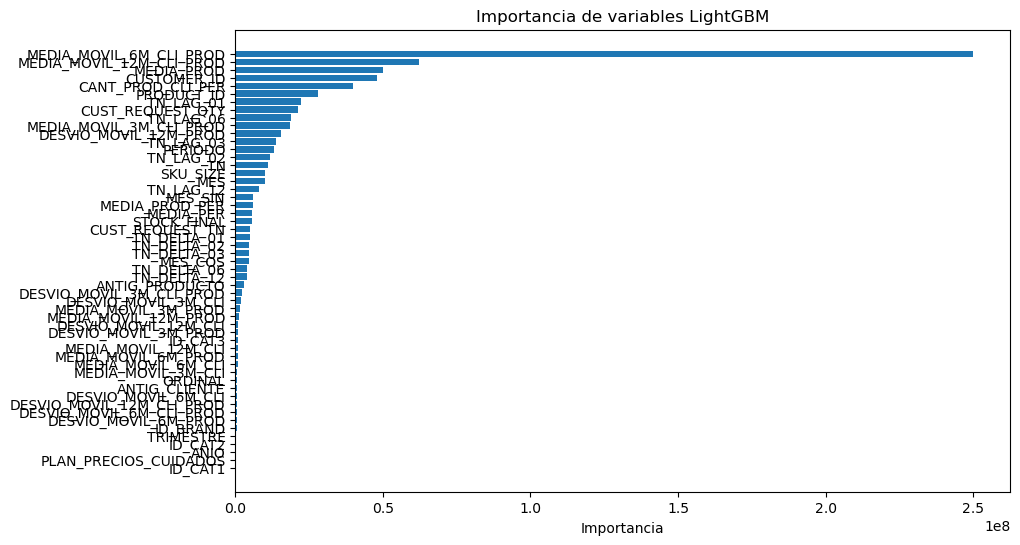

In [22]:
# Obtener la importancia de cada variable
importancia = model_reg.feature_importance(importance_type='gain')
nombres = X_train.columns

# Crear un DataFrame ordenado por importancia
df_importancia = pd.DataFrame({'feature': nombres, 'importance': importancia})
df_importancia = df_importancia.sort_values(by='importance', ascending=False)

# Mostrar las variables más importantes
print(df_importancia)

# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables LightGBM')
plt.xlabel('Importancia')
plt.show()

In [23]:
# --- PREDICCIÓN Y EVALUACIÓN por periodo ---
for i, (X_val, y_val, periodo) in enumerate(zip(X_val_list, y_val_list, periodos_valid)):
    proba_no_cero = model_clasif.predict(X_val)
    umbral = 0.25
    pred_bin = (proba_no_cero > umbral)
    pred_reg = np.zeros(len(X_val))
    if pred_bin.sum() > 0:
        pred_reg[pred_bin] = model_reg.predict(X_val[pred_bin])
    y_val_real = y_val.values
    # WAPE solo en no-cero
    mask_nocero = y_val_real != 0
    if mask_nocero.sum() > 0:
        wape_nocero = np.sum(np.abs(y_val_real[mask_nocero] - pred_reg[mask_nocero])) / np.sum(np.abs(y_val_real[mask_nocero]))
        print(f"WAPE (no-cero) periodo {periodo}: {wape_nocero:.4f}")
    else:
        print(f"WAPE (no-cero) periodo {periodo}: N/A (no hay valores no-cero)")
    # También puedes seguir mostrando el WAPE global
    wape = np.sum(np.abs(y_val_real - pred_reg)) / np.sum(np.abs(y_val_real))
    print(f"WAPE global periodo {periodo}: {wape:.4f}")
    print(f"Valores distintos de cero en pred_reg: {(pred_reg != 0).sum()} de {len(pred_reg)}")

WAPE (no-cero) periodo 201910: 0.6678
WAPE global periodo 201910: 0.9318
Valores distintos de cero en pred_reg: 88826 de 460200


In [24]:
# Armar listado de las 100 predicioones con mayor diferencia entre predicción y valor real con product_id, customer_id 
df_val = X_val_list[0].copy()
df_val['CLASE_REAL'] = y_val_list[0].values
df_val['CLASE_PRED'] = pred_reg
df_val['DIF'] = np.abs(df_val['CLASE_REAL'] - df_val['CLASE_PRED'])
df_val = df_val.sort_values(by='DIF', ascending=False).head(50)
df_val[['PRODUCT_ID', 'CUSTOMER_ID', 'CLASE_REAL', 'CLASE_PRED', 'DIF']]
# Agrupar las diferencias por PRODUCT_ID


,PRODUCT_ID,CUSTOMER_ID,CLASE_REAL,CLASE_PRED,DIF
17777,20001,10013,243.981735,73.405255,170.576480
37343,20002,10001,334.037140,184.436118,149.601022
17786,20001,10004,34.648102,145.596344,110.948242
37340,20002,10004,174.133194,76.068395,98.064799
37341,20002,10003,2.455250,92.738790,90.283540
96072,20005,10019,95.697060,10.192865,85.504195
193783,20010,10002,101.285179,25.118606,76.166573
56899,20003,10001,137.987167,70.676506,67.310661
115563,20006,10002,87.244034,24.276152,62.967881
135117,20007,10002,72.651817,14.945093,57.706725


In [27]:
df_dif_product = df_val.groupby('PRODUCT_ID')['DIF'].sum().reset_index()
print("Diferencias promedio por PRODUCT_ID:")   
df_dif_product.sort_values(by='DIF', ascending=False).head(50)


Diferencias promedio por PRODUCT_ID:


,PRODUCT_ID,DIF
0,20001,478.240128
1,20002,470.144468
2,20003,252.970277
5,20006,105.849603
8,20010,104.060696
18,20032,85.793042
4,20005,85.504195
6,20007,83.223237
7,20009,82.246274
13,20017,70.208819


In [ ]:
# Agrupar las diferencias por CUSTOMER_ID
df_dif_customer = df_val.groupby('CUSTOMER_ID')['DIF'].sum().reset_index()
print("Diferencias promedio por CUSTOMER_ID:")
df_dif_customer.sort_values(by='DIF', ascending=False).head(50)



Diferencias promedio por CUSTOMER_ID:


,CUSTOMER_ID,DIF
10,10013,100.823977
13,10019,85.504195
3,10004,81.022876
2,10003,52.040875
0,10001,48.613101
1,10002,44.750883
12,10017,42.992728
7,10008,40.057140
11,10015,39.369445
15,10022,38.484784


In [ ]:
# Cargo los datos sobre los que quiero hacer predicciones

conn =  cx_Oracle.connect(user="pc",password="p201404",dsn="siatchdesa")
query = "select * from L_VM_COMPLETA where periodo = 201912" 
df_pred = pd.read_sql(query, conn, chunksize=1000000)  # Lee en chunks para no llenar la RAM

# Para concatenar todos los chunks en un solo DataFrame (si tienes suficiente RAM)
df_pred_full = pd.concat(df_pred, ignore_index=True)
conn.close()

In [ ]:
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

# Con el modelo entrenado, hacemos predicciones 
X_pred = df_pred_full[['PERIODO','CUSTOMER_ID','PRODUCT_ID',
'TN_DELTA_01','TN_DELTA_02','TN_DELTA_03','TN_DELTA_06','TN_DELTA_12']]


In [ ]:

predictions = model.predict(X_pred)
# Agregar las predicciones al DataFrame original
df_pred_full['PREDICCIONES'] = predictions
# Imprimir las primeras filas del DataFrame con las predicciones
print(df_pred_full.head())
# Guardar el DataFrame con las predicciones en un archivo CSV
df_pred_full.to_csv('predicciones.csv', index=False)
# Imprimir el número de filas y columnas del DataFrame con las predicciones
print(f"Número de filas: {df_pred_full.shape[0]}, Número de columnas: {df_pred_full.shape[1]} con predicciones.")



In [ ]:
# Con el DataFrame de predicción, actualizamos la base de datos
# el criterio es actualizar la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones
# la columnna PREDICCIONES se debe actualizar con los nuevos valores
# la clave primaria es (PERIODO, CUSTOMER_ID, PRODUCT_ID)
# Hacer commit cada 10000 filas para evitar problemas de memoria

# Conectar a la base de datos para actualizar los datos de predicción
conn = cx_Oracle.connect(user="pc", password="p201404", dsn="siatchdesa")
# Crear un cursor para ejecutar las actualizaciones
cursor = conn.cursor()
update_query = """
    UPDATE L_VM_COMPLETA_PREDICCIONES
    SET PREDICCION = NULL
"""
cursor.execute(update_query)
# Hacer commit para aplicar el cambio de NULL
conn.commit()


In [ ]:


# Imprimir mensaje de inicio de actualización
print("Iniciando actualización de la tabla L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")

# Iterar sobre las filas del DataFrame con las predicciones
for index, row in df_pred_full.iterrows():
    periodo = row['PERIODO']
    customer_id = row['CUSTOMER_ID']
    product_id = row['PRODUCT_ID']
    prediccion = row['TN'] + row['PREDICCIONES']
   # prediccion = row['PREDICCIONES']
    
    # Actualizar la tabla L_DATOS_PREDICCION con la nueva predicción
    update_query = """
        UPDATE L_VM_COMPLETA_PREDICCIONES
        SET PREDICCION = :prediccion
        WHERE PERIODO = :periodo AND CUSTOMER_ID = :customer_id AND PRODUCT_ID = :product_id
    """
    cursor.execute(update_query, {'prediccion': prediccion, 'periodo': periodo, 'customer_id': customer_id, 'product_id': product_id})  
    # Hacer commit cada 10000 filas para evitar problemas de memoria
    if index % 10000 == 0:
        conn.commit()
        print(f"Actualizadas {index} filas de L_VM_COMPLETA_PREDICCIONES con las nuevas predicciones.")
# Confirmar los cambios en la base de datos
conn.commit()
# Cerrar el cursor y la conexión
cursor.close()
conn.close()
# Imprimir mensaje de finalización
print("Actualización de la tabla  completada con las nuevas predicciones.")
